In [1]:
from qiskit.transpiler.passes.routing.sabre_swap_v020 import SabreSwap
from qiskit.transpiler.passes.layout.sabre_layout_v020 import SabreLayout
from ulti.circuits import get_circuit_list, sort_circuits_by_depth
from ulti.coupling_maps import file_to_coupling_map
from ulti.pass_managers import generate_pass_managers, transpiled_data
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import random
random.seed(42)
import os

# Runs the experiment for SabreSwap v0.20 and SabreLayout v0.20


In [2]:
# Variables to change
qc_name = "size5_depth_1-30"

experiment_name = "sabre_extended"
version = "20" # version for the routing pass after _v0.
lp_name = "sabre_0.20"
cp_name = "heavy_hex_27"

In [3]:
num_shots = 5
rp = SabreSwap
lp = SabreLayout
cm = file_to_coupling_map(f'coupling_maps/{cp_name}.txt')
pm = generate_pass_managers(num_shots, rp, lp, cm)


rp_name = experiment_name + "_v0." + version
qc_list = get_circuit_list([f'circuits/{qc_name}/'])
qc_list = sort_circuits_by_depth(qc_list)

csv_file_path = f'data/{qc_name}/{experiment_name}_v0{version}.csv'
directory = f'data/{qc_name}'
if not os.path.exists(directory):
        os.makedirs(directory)

In [4]:
data_list = []
for qc_idx, qc in enumerate(qc_list):
    data = transpiled_data(qc, pm)
    data['routing pass'] = rp_name
    data['layout pass'] = lp_name
    data['coupling map'] = cp_name
    data['circuit label'] = qc_idx
    data_list.append(data)

    print(f"Finished {qc_idx}")
print("Finished all")

Finished 0
Finished 1
Finished 2
Finished 3
Finished 4
Finished 5
Finished 6
Finished 7
Finished 8
Finished 9
Finished 10
Finished 11
Finished 12
Finished 13
Finished 14
Finished 15
Finished 16
Finished 17
Finished 18
Finished 19
Finished 20
Finished 21
Finished 22
Finished 23
Finished 24
Finished 25
Finished 26
Finished 27
Finished 28
Finished all


In [5]:
df = pd.DataFrame(data_list)
df.to_csv(csv_file_path, index=False)
df

,best_data,std_dev,routing pass,layout pass,coupling map,circuit label
0,"{'depth': 1, 'depth_ratio': 1.0, 'time': 0.008...","{'depth': 0, 'depth_ratio': 0, 'time': 0.00019...",sabre_extended_v0.20,sabre_0.20,heavy_hex_27,0
1,"{'depth': 2, 'depth_ratio': 1.0, 'time': 0.011...","{'depth': 1.939, 'depth_ratio': 0.9695, 'time'...",sabre_extended_v0.20,sabre_0.20,heavy_hex_27,1
2,"{'depth': 3, 'depth_ratio': 1.0, 'time': 0.013...","{'depth': 0, 'depth_ratio': 0, 'time': 0.01785...",sabre_extended_v0.20,sabre_0.20,heavy_hex_27,2
3,"{'depth': 7, 'depth_ratio': 1.75, 'time': 0.01...","{'depth': 0, 'depth_ratio': 0, 'time': 0.00055...",sabre_extended_v0.20,sabre_0.20,heavy_hex_27,3
4,"{'depth': 14, 'depth_ratio': 2.8, 'time': 0.02...","{'depth': 2.638, 'depth_ratio': 0.5276, 'time'...",sabre_extended_v0.20,sabre_0.20,heavy_hex_27,4
5,"{'depth': 12, 'depth_ratio': 2.0, 'time': 0.02...","{'depth': 2.449, 'depth_ratio': 0.4066, 'time'...",sabre_extended_v0.20,sabre_0.20,heavy_hex_27,5
6,"{'depth': 13, 'depth_ratio': 1.86, 'time': 0.0...","{'depth': 2.0, 'depth_ratio': 0.284, 'time': 0...",sabre_extended_v0.20,sabre_0.20,heavy_hex_27,6
7,"{'depth': 23, 'depth_ratio': 2.88, 'time': 0.0...","{'depth': 1.02, 'depth_ratio': 0.1255, 'time':...",sabre_extended_v0.20,sabre_0.20,heavy_hex_27,7
8,"{'depth': 20, 'depth_ratio': 2.22, 'time': 0.0...","{'depth': 1.673, 'depth_ratio': 0.1888, 'time'...",sabre_extended_v0.20,sabre_0.20,heavy_hex_27,8
9,"{'depth': 28, 'depth_ratio': 2.8, 'time': 0.03...","{'depth': 5.238, 'depth_ratio': 0.5238, 'time'...",sabre_extended_v0.20,sabre_0.20,heavy_hex_27,9


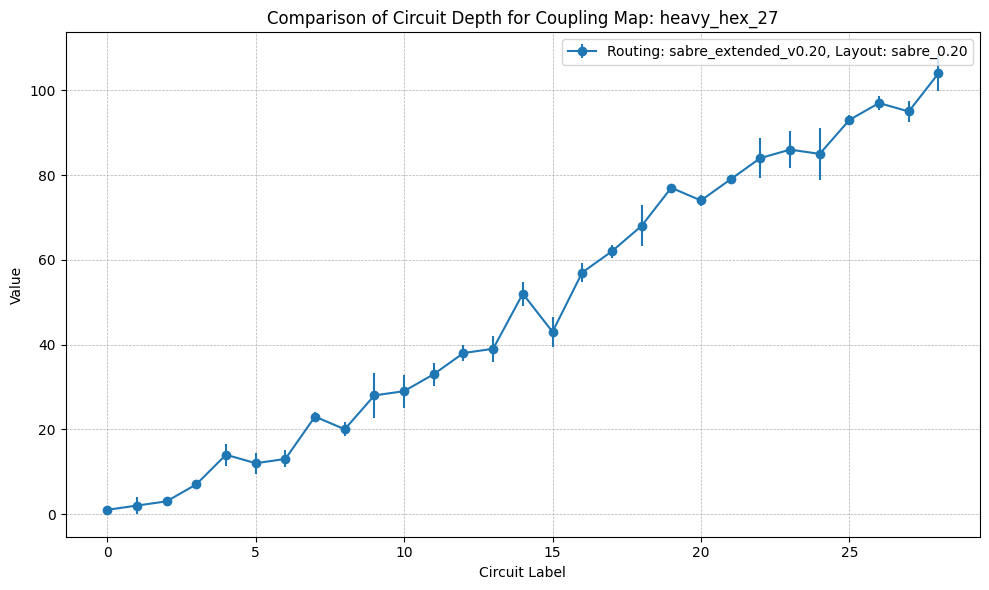

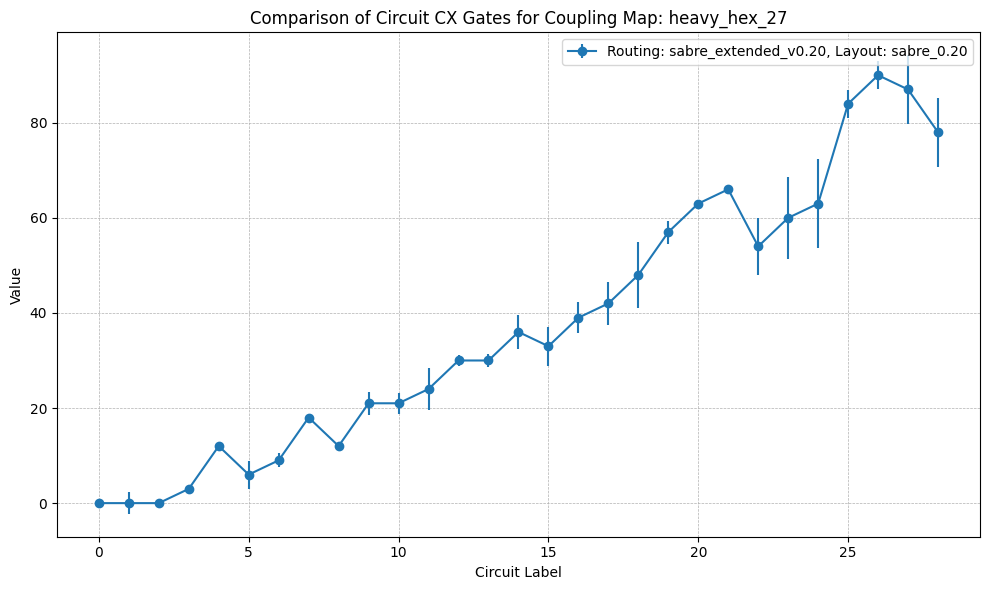

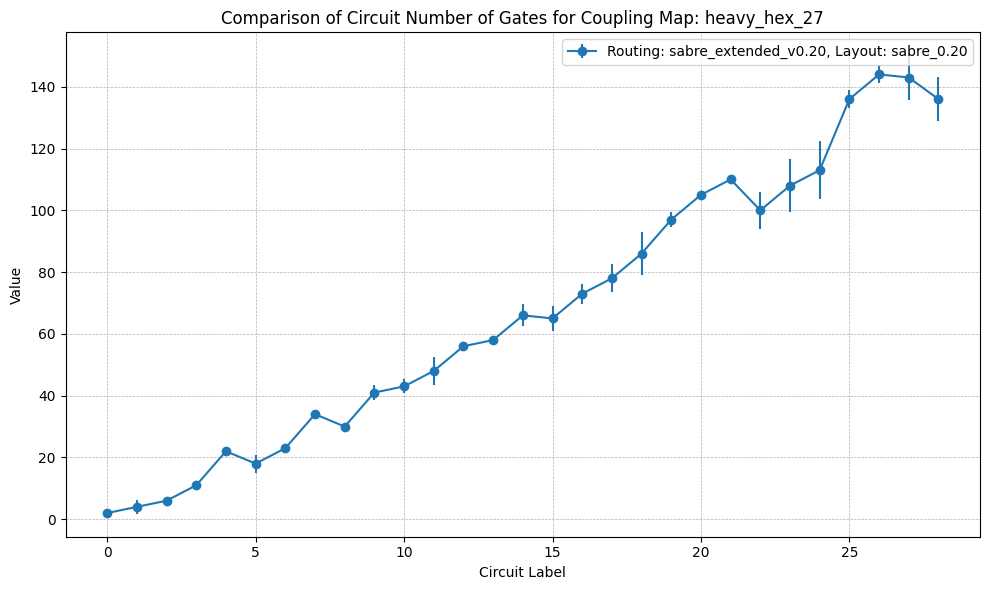

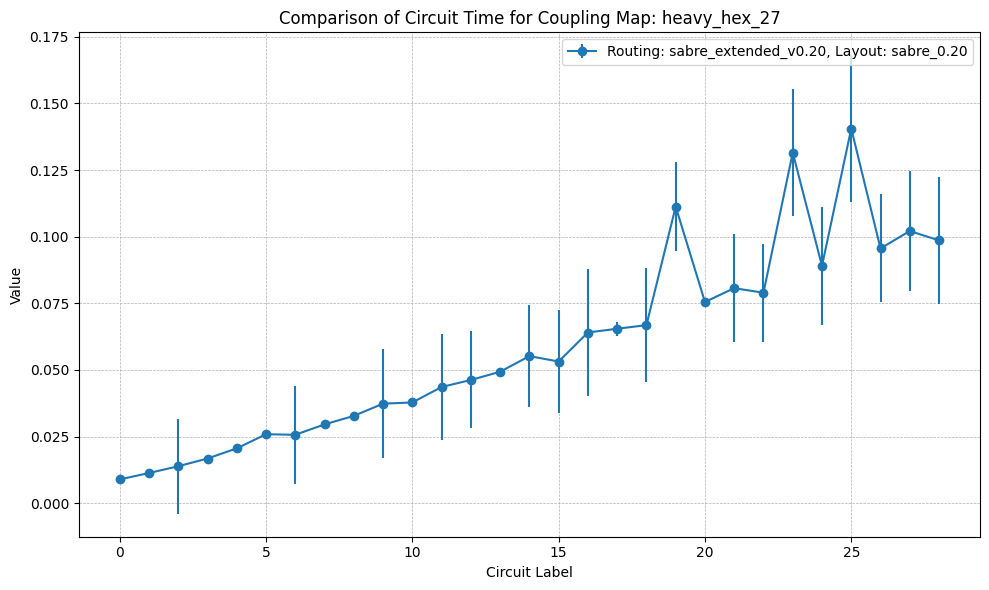

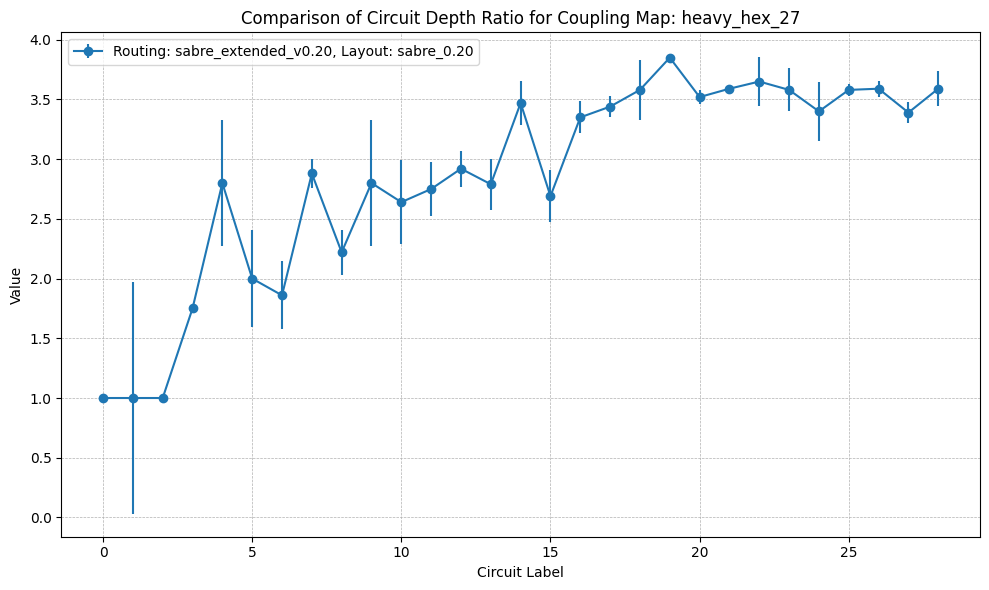

In [6]:
data = pd.read_csv(csv_file_path)

# Convert the string representation of dictionaries into actual dictionaries
data['best_data'] = data['best_data'].apply(literal_eval)
data['std_dev'] = data['std_dev'].apply(literal_eval)

# Extract the data from the 'best_data' and 'std_dev' columns and add them to the DataFrame
for col in ['depth', 'depth_ratio', 'time', 'cx_gates', 'num_gates']:
    data[f"best_{col}"] = data['best_data'].apply(lambda x: x[col])
    data[f"std_dev_{col}"] = data['std_dev'].apply(lambda x: x[col])

metrics = [
    ("depth", "Depth"),
    ("cx_gates", "CX Gates"),
    ("num_gates", "Number of Gates"),
    ("time", "Time"),
    ("depth_ratio", "Depth Ratio")
]

unique_routing_layout_combinations = data[['routing pass', 'layout pass']].drop_duplicates().values

for metric, label in metrics:
    plt.figure(figsize=(10, 6))
    for routing_pass, layout_pass in unique_routing_layout_combinations:
        subset = data[(data['routing pass'] == routing_pass) & (data['layout pass'] == layout_pass)]
        plt.errorbar(subset['circuit label'], subset[f"best_{metric}"], yerr=subset[f"std_dev_{metric}"], fmt='o-', label=f'Routing: {routing_pass}, Layout: {layout_pass}')
    plt.xlabel('Circuit Label')
    plt.ylabel('Value')
    plt.title(f'Comparison of Circuit {label} for Coupling Map: {data["coupling map"].iloc[0]}')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    #plt.savefig(f"data/graphs/{qc_name}/{experiment_name}_v0{version}/{label.replace(' ', '_').lower()}.png")
    plt.show()
    plt.close()